In [36]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
import zipfile

with zipfile.ZipFile("mit-bih-arrhythmia-database-1.0.0.zip", 'r') as zip_ref:
    zip_ref.extractall("mitdb")

In [ ]:
# Installer les bibliothèques requises (à exécuter une fois)
!pip install wfdb scikit-learn matplotlib tensorflow


In [ ]:
# Installer la bibliothèque wfdb si nécessaire
!pip install wfdb

import wfdb
import matplotlib.pyplot as plt

# Télécharger l'enregistrement '100' depuis PhysioNet
wfdb.dl_database('mitdb', dl_dir='mit-bih-arrhythmia-database-1.0.0', records=['100'])

# Lire les données
record = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/100')
annotation = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100', 'atr')

# Afficher le signal et les annotations (premiers 1000 échantillons)
plt.figure(figsize=(10, 4))
plt.plot(record.p_signal[:1000, 0], label='ECG signal')
plt.title('Signal ECG - Canal 1 (Patient 100)')
plt.xlabel('Échantillons')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
!ls /content/mit-bih-arrhythmia-database-1.0.0

100.atr  100.dat  100.hea


In [ ]:
import numpy as np

def extract_beats(record, annotation, window_size=100):
    """
    Extrait les battements ECG autour des annotations.
    Chaque fenêtre a une taille de 2*window_size (ex: 200 échantillons).
    """
    beats = []
    labels = []
    signal = record.p_signal[:, 0]  # Utilise seulement le 1er canal

    for i, idx in enumerate(annotation.sample):
        if idx - window_size >= 0 and idx + window_size <= len(signal):
            beat = signal[idx - window_size: idx + window_size]
            label = annotation.symbol[i]
            beats.append(beat)
            labels.append(label)

    return np.array(beats), np.array(labels)

beats, labels = extract_beats(record, annotation)
print(f"Nombre de battements extraits : {len(beats)}")


In [ ]:
def label_to_binary(y):
    return np.array([0 if label == 'N' else 1 for label in y])

y_binary = label_to_binary(labels)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(beats, y_binary, test_size=0.2, random_state=42)

# Appliquer un reshape car RandomForest attend 2D (n_samples, n_features)
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

# Entraînement
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Évaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


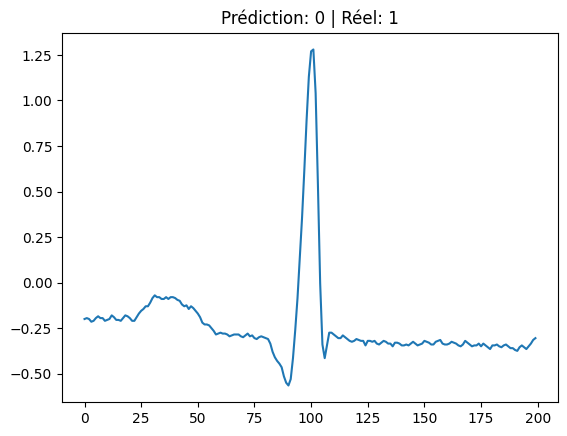

In [39]:
import matplotlib.pyplot as plt

# Trouver un exemple mal classé
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        plt.plot(X_test[i])
        plt.title(f"Prédiction: {y_pred[i]} | Réel: {y_test[i]}")
        plt.show()
        break


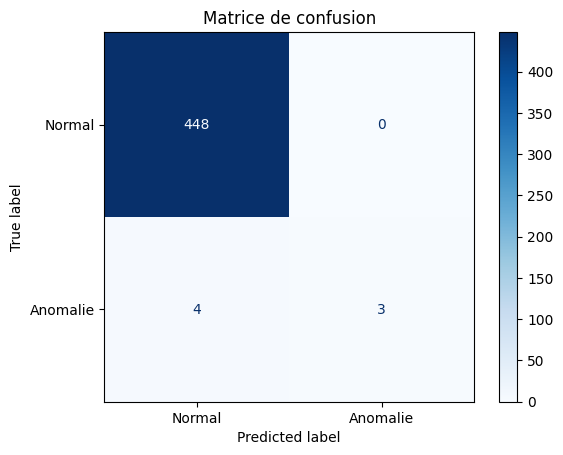

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# L'afficher joliment
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomalie'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


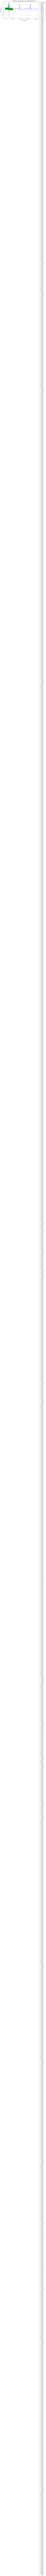

In [44]:
import wfdb
import matplotlib.pyplot as plt

# Fonction de prédiction ECG
def predict_ecg(file_path, clf, window_size=100):
    """
    Prédire les anomalies sur un enregistrement ECG et afficher les résultats.
    """
    # Construire le chemin complet pour l'enregistrement
    record_path = f'/content/mit-bih-arrhythmia-database-1.0.0/{file_path}'

    # Lire le fichier ECG et ses annotations
    try:
        record = wfdb.rdrecord(f'{record_path}')
        annotation = wfdb.rdann(f'{record_path}', 'atr')
    except FileNotFoundError:
        print(f"Fichier pour l'enregistrement {file_path} non trouvé.")
        return

    # Extraire les battements
    beats, labels = extract_beats(record, annotation, window_size)

    # Convertir les labels en format binaire (normal/anomalie)
    y_binary = label_to_binary(labels)

    # Prédire les anomalies
    y_pred = clf.predict(beats)

    # Visualiser le signal ECG et les anomalies
    signal = record.p_signal[:, 0]  # Utilise uniquement le premier canal
    plt.figure(figsize=(10, 4))
    plt.plot(signal[:1000], label='ECG signal', color='blue')

    # Ajouter les prédictions d'anomalies
    for i, prediction in enumerate(y_pred):
        if prediction == 1:  # Anomalie
            plt.plot(beats[i], color='red', label='Anomalie', alpha=0.6)
        else:  # Normal
            plt.plot(beats[i], color='green', label='Normal', alpha=0.6)

    plt.title(f"Prédiction des anomalies ECG - Enregistrement {file_path}")
    plt.xlabel('Échantillons')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation avec l'enregistrement '100' et le modèle RandomForest déjà entraîné
predict_ecg("100", clf)


In [40]:
from google.colab import files
import zipfile
import os

# Télécharge le fichier ZIP
uploaded = files.upload()

# Décompresser l'archive ZIP
with zipfile.ZipFile("mit-bih-arrhythmia-database-1.0.0.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/mitdb")

# Vérifier que les fichiers sont extraits correctement
extracted_files = os.listdir('/content/mitdb')
print(extracted_files)  # Affiche le contenu du dossier pour voir si les fichiers sont bien extraits


['mit-bih-arrhythmia-database-1.0.0']
